In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
#az.style.use('arviz-whitegrid')

In [2]:
# # data was taken from
# # https://github.com/owid/covid-19-data/tree/master/public/data
# # on 16.05.2020

# df = pd.read_csv('covid19_1605.csv')
# df['lethality_mle'] = df.total_deaths / df.total_cases
# df

,location,total_cases,total_deaths,lethality_mle
0,Afghanistan,6402,168,0.026242
1,Albania,916,31,0.033843
2,Algeria,6629,536,0.080857
3,Andorra,761,49,0.064389
4,Angola,48,2,0.041667
...,...,...,...,...
205,Vietnam,313,0,0.000000
206,Western Sahara,6,0,0.000000
207,Yemen,106,15,0.141509
208,Zambia,668,7,0.010479


In [3]:
# countries = ['Angola', 'Kazakhstan', 'Russia', 'Seychelles']
# df = df[df.location.isin(countries)]
# df

,location,total_cases,total_deaths,lethality_mle
4,Angola,48,2,0.041667
102,Kazakhstan,5850,34,0.005812
157,Russia,262843,2418,0.009199
167,Seychelles,11,0,0.000000


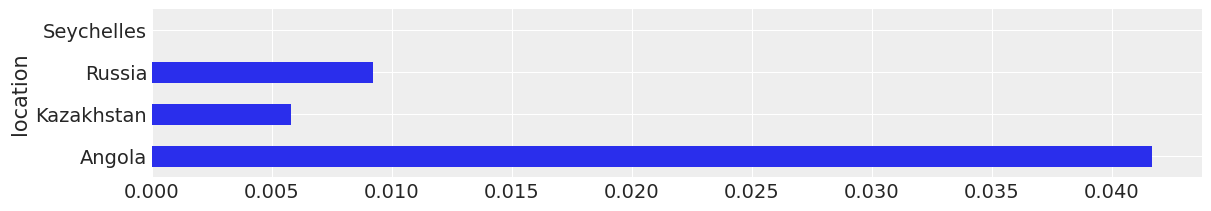

In [4]:
# x = df.set_index('location')
# x.lethality_mle.plot(kind='barh', 
#                  use_index=True,
#                  figsize=(12,2))
# plt.show()

In [5]:
#cases_arr = np.array(df.total_cases)
#deaths_arr = np.array(df.total_deaths)

cases_arr = np.array([10, 50, 10, 1])
deaths_arr = np.array([5, 3, 0, 1])

# model:
#
# y_ij ~ Be(theta_j)
# theta_j ~ Beta(omega, kappa)
# omega ~ Beta(1, 1)
# kappa - 2 ~ Gamma(100, 10)

with pm.Model() as model:
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa', 100, 10)
    theta = pm.Beta('theta', 
                    alpha=omega*kappa_minus2 + 1, 
                    beta=(1.0-omega)*kappa_minus2 + 1, 
                    shape=deaths_arr.shape)
    y = pm.Binomial('y', n=cases_arr, p=theta, observed=deaths_arr)
    inf_data = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa, omega]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


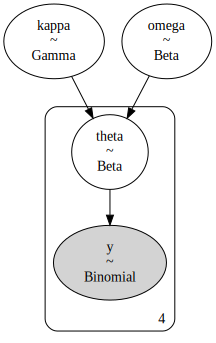

In [6]:
pm.model_to_graphviz(model)

In [11]:
inf_data.posterior['omega'].values.shape

(2, 2000)

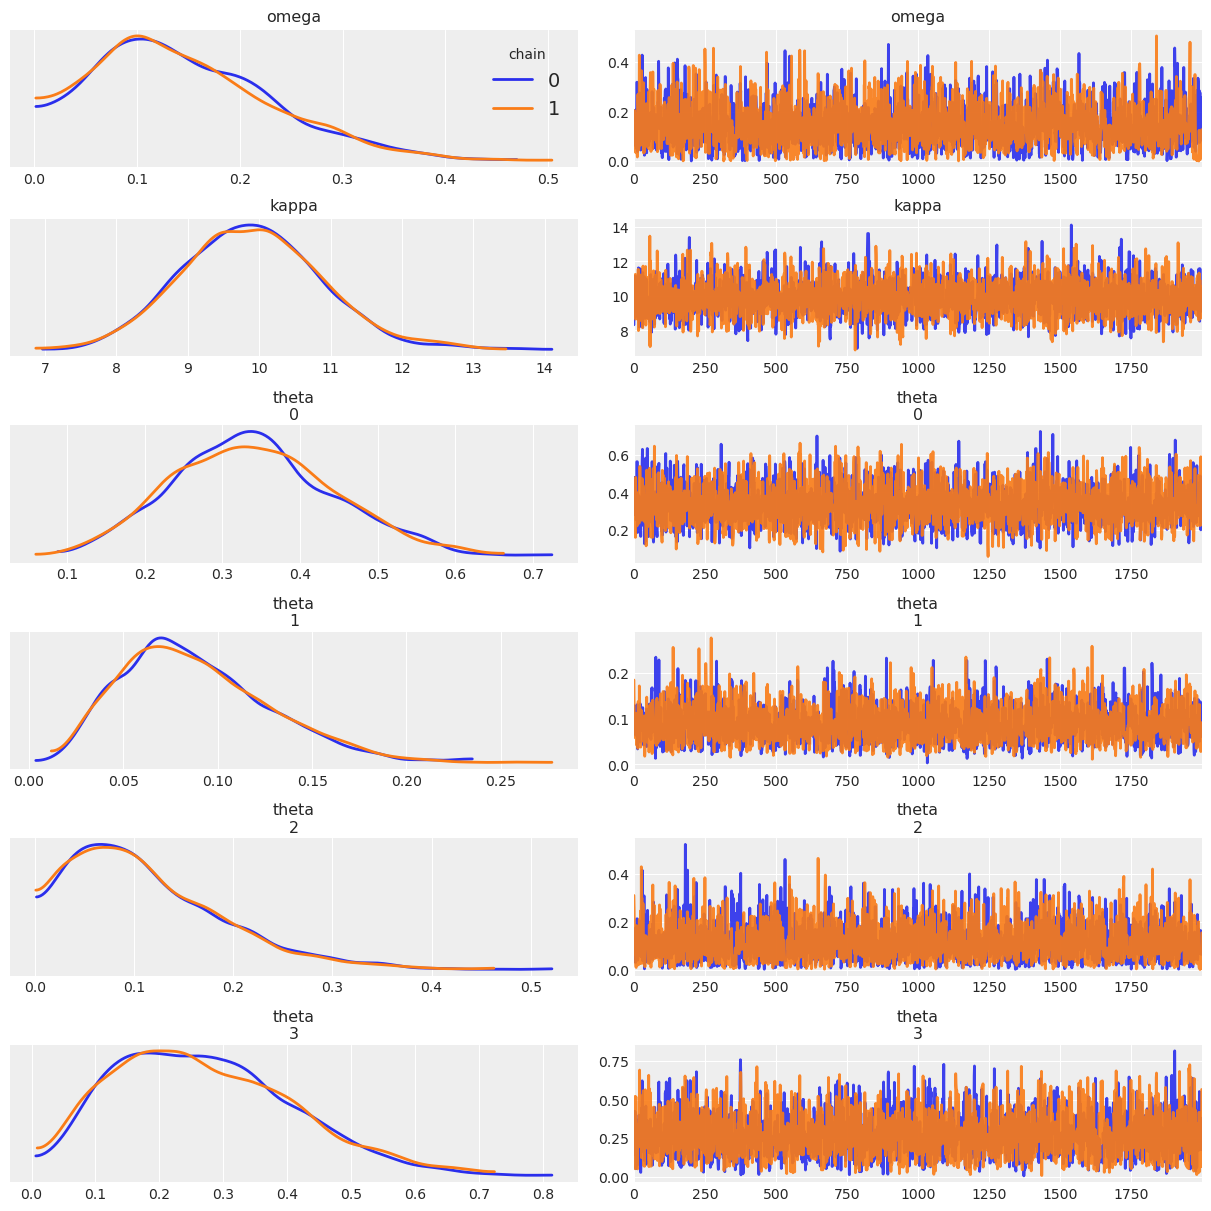

In [12]:
az.plot_trace(inf_data, legend=True, figsize=(12,12),
              trace_kwargs={'linewidth' : 2,
                            'alpha' : 0.9},
              plot_kwargs={'linewidth' : 2,
                           'alpha' : 1},
              compact = False
             )
plt.show()

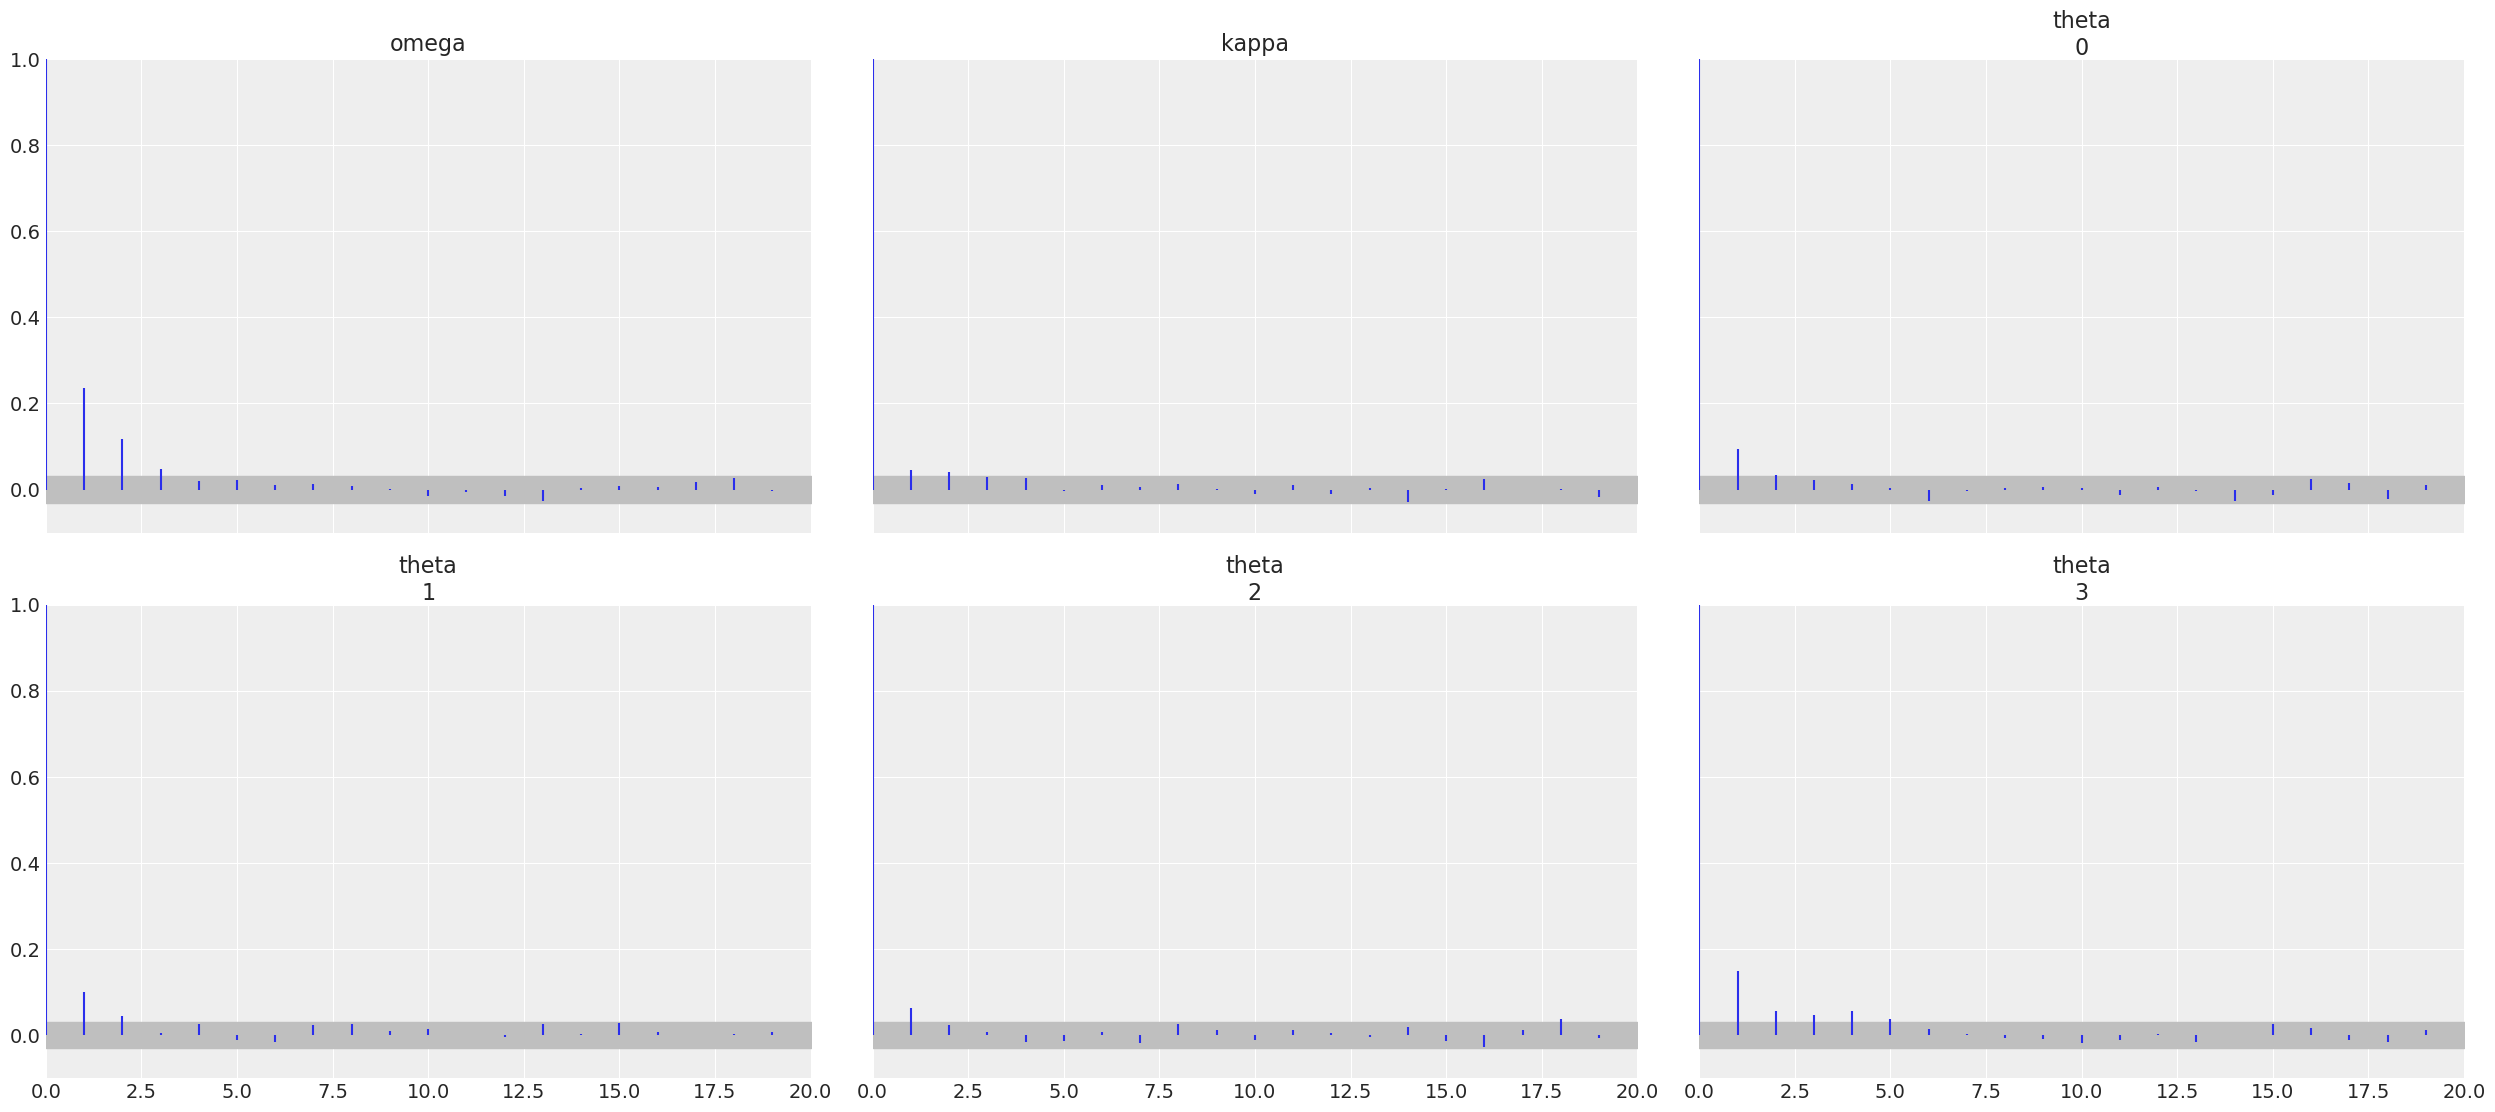

In [13]:
az.plot_autocorr(inf_data, max_lag=20, combined=True)
plt.ylim([-0.1, 1])
plt.show()

In [14]:
az.rhat(inf_data)

<xarray.Dataset>
Dimensions:      (theta_dim_0: 4)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3
Data variables:
    omega        float64 1.0
    kappa        float64 1.0
    theta        (theta_dim_0) float64 1.001 1.0 0.9998 1.001

In [15]:
az.ess(inf_data)

<xarray.Dataset>
Dimensions:      (theta_dim_0: 4)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3
Data variables:
    omega        float64 1.881e+03
    kappa        float64 3.13e+03
    theta        (theta_dim_0) float64 3.056e+03 2.869e+03 2.973e+03 2.275e+03

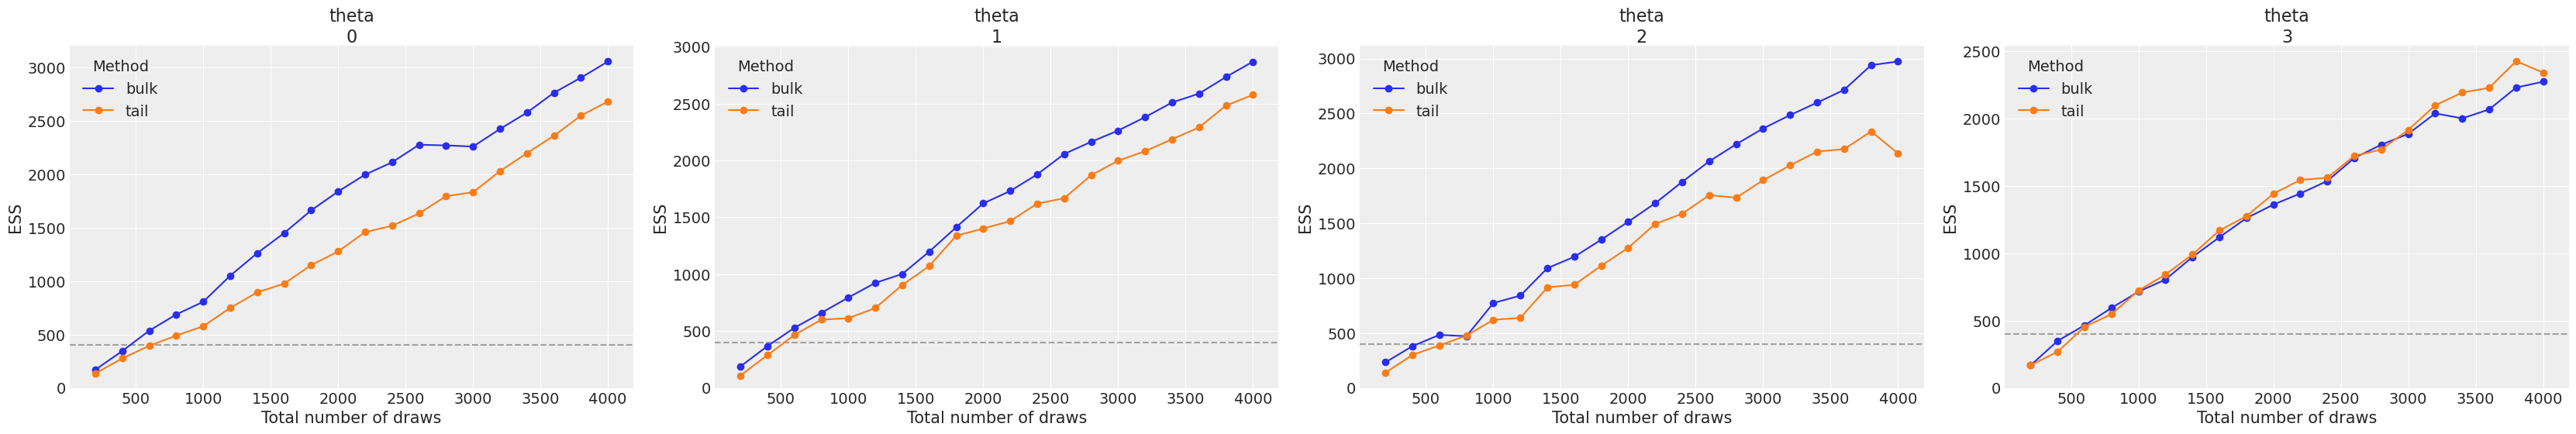

In [16]:
az.plot_ess(inf_data, var_names=['theta'], kind="evolution")
plt.show()

In [17]:
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.146,0.087,0.001,0.297,0.002,0.001,1881.0,1354.0,1.0
kappa,9.901,0.991,7.995,11.663,0.018,0.013,3130.0,2388.0,1.0
theta[0],0.341,0.104,0.147,0.533,0.002,0.001,3056.0,2683.0,1.0
theta[1],0.089,0.040,0.023,0.161,0.001,0.001,2869.0,2578.0,1.0
theta[2],0.113,0.077,0.000,0.250,0.001,0.001,2973.0,2136.0,1.0
theta[3],0.271,0.139,0.031,0.519,0.003,0.002,2275.0,2342.0,1.0


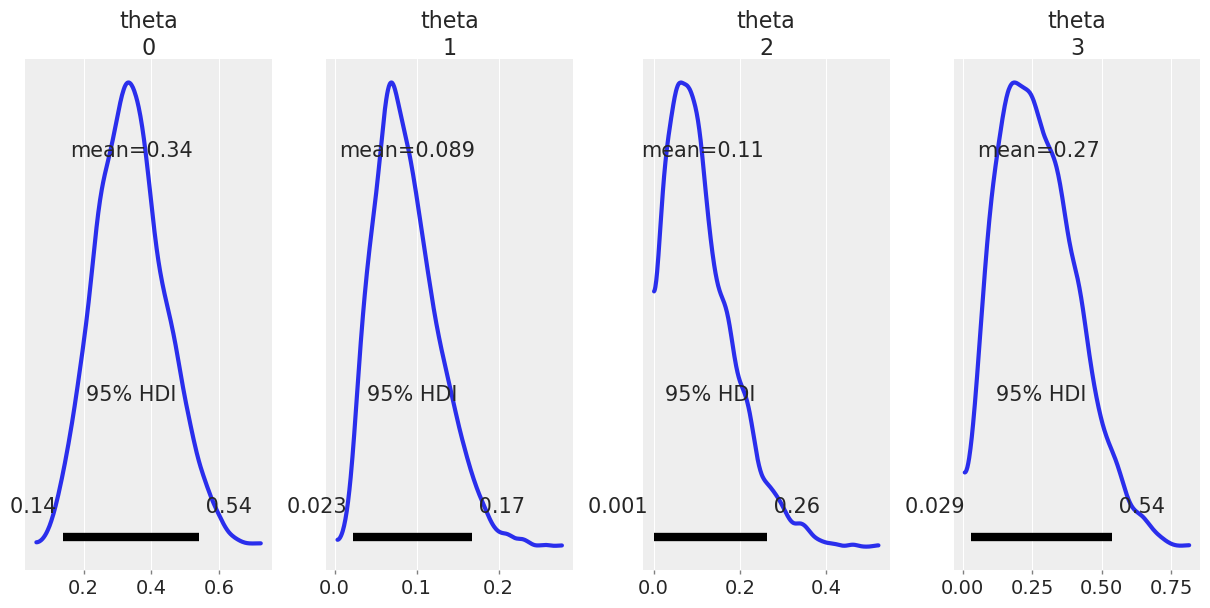

In [18]:
az.plot_posterior(inf_data, var_names=['theta'],
                  hdi_prob=0.95,
                  figsize=(12,6),
                  lw=3)
plt.show()

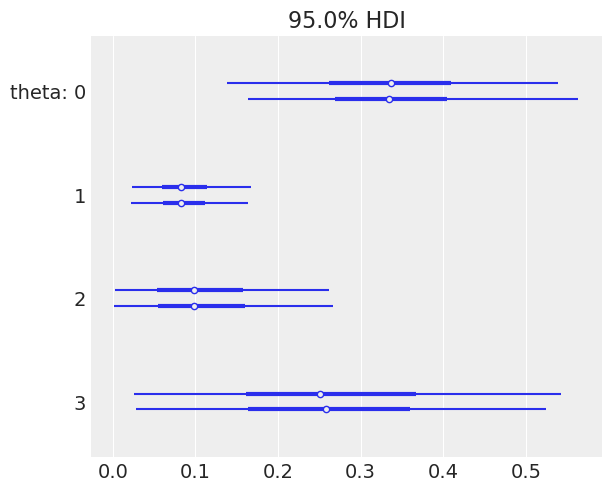

In [19]:
az.plot_forest(inf_data, var_names=['theta'], #combined=True,
               hdi_prob=0.95,
              )#r_hat=True, ess=True)
plt.show()

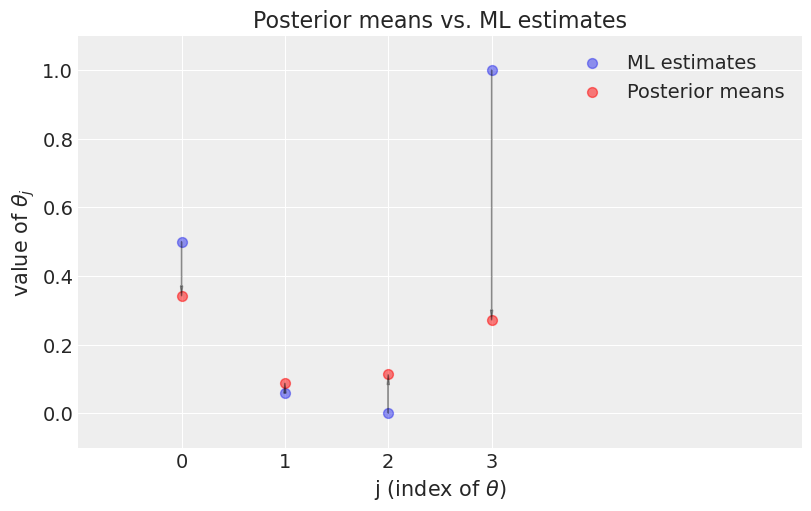

In [20]:
# shrinkage effect
posterior_means = inf_data.posterior['theta'].mean(axis=(0,1))
mle = deaths_arr / cases_arr

fig = plt.figure(figsize=(8, 5))
theta_indices = np.arange(posterior_means.shape[0])
ax = fig.add_subplot(111, xlabel='j (index of $\\theta$)', ylabel='value of $\\theta_j$', 
                     title='Posterior means vs. ML estimates', 
                     xlim=(-1, 3+theta_indices.max()), ylim=(-0.1, 1.1), xticks=theta_indices)

ax.scatter(theta_indices, mle, s=50, alpha=0.5, label='ML estimates')
ax.scatter(theta_indices, posterior_means, c='red', s=50, alpha=0.5, label='Posterior means')
for i in range(len(theta_indices)):  
    ax.arrow(theta_indices[i], mle[i], 0, posterior_means[i] - mle[i], 
             fc="k", ec="k", length_includes_head=True, alpha=0.4, head_width=.02)
ax.legend();

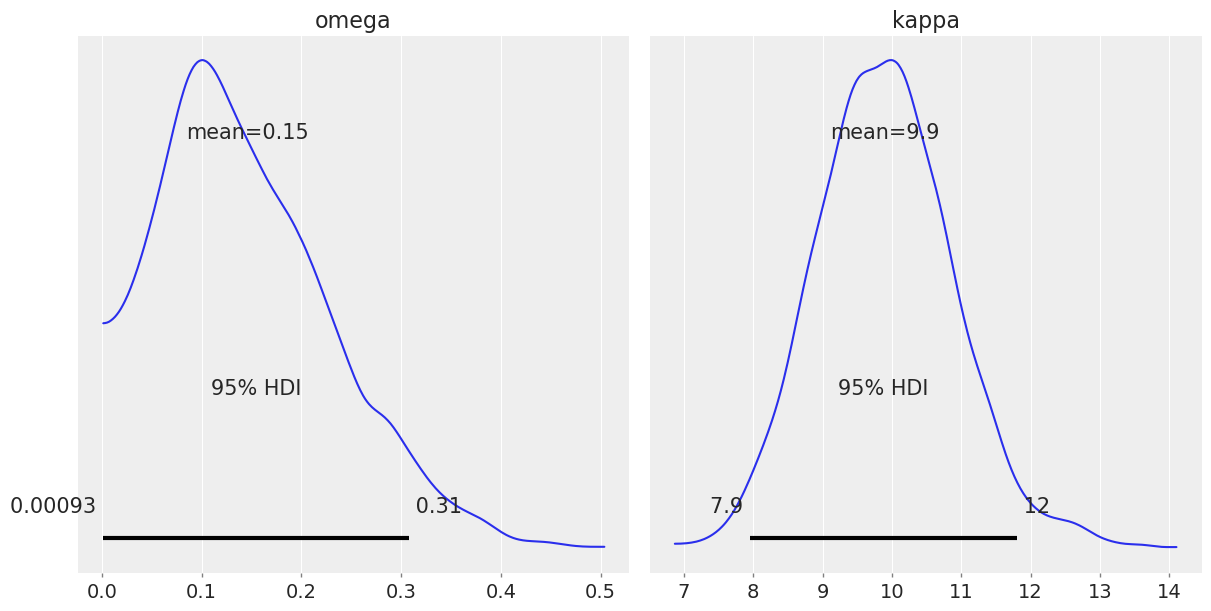

In [21]:
pm.plot_posterior(inf_data, var_names=['omega', 'kappa'],
                  hdi_prob=0.95,
                  figsize=(12,6))
plt.show()

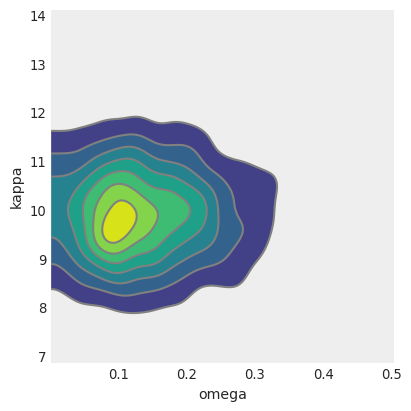

In [22]:
az.plot_pair(inf_data, var_names=['omega', 'kappa'], 
             kind='kde', fill_last=False,
            figsize=(4,4))
plt.show()

In [23]:
inf_data.posterior['theta'].shape
# (chain, sample, parameter)

(2, 2000, 4)

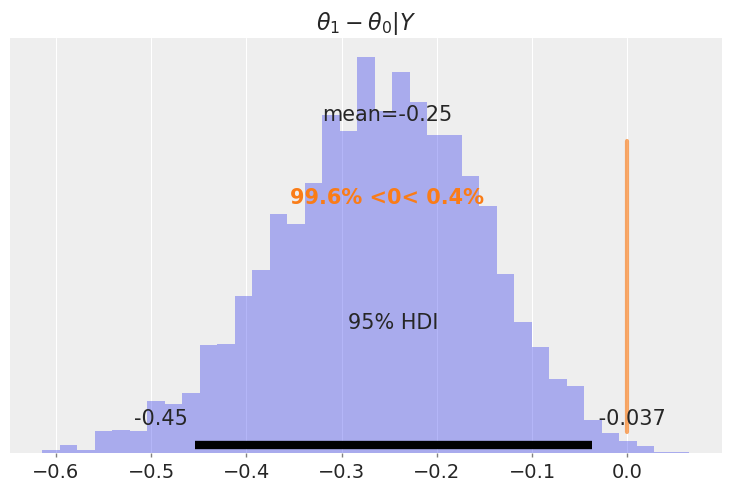

In [24]:
theta_diff = inf_data.posterior['theta'][:,:,1] - inf_data.posterior['theta'][:,:,0]
az.plot_posterior(theta_diff, hdi_prob=0.95,
                  ref_val = 0,
                  kind='hist',
                  lw=3
                 )
plt.title('$\\theta_1-\\theta_0 | Y$')
#plt.xlim([-0.053,-0.05])
#plt.xlim([-0.8, 0.1])
plt.show()

In [25]:
from scipy.stats import beta

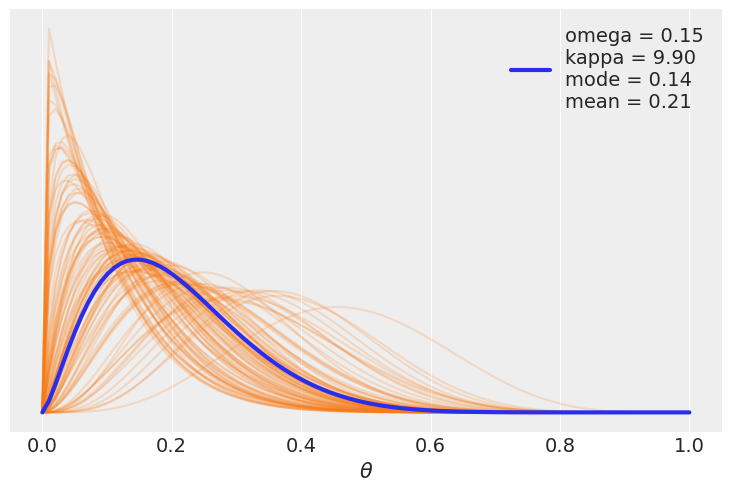

In [26]:
omega_trace = inf_data.posterior['omega'].values.reshape(-1)
kappa_trace = inf_data.posterior['kappa'].values.reshape(-1)

x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(omega_trace), size=100):
    u = omega_trace[i]
    k = kappa_trace[i]
    pdf = beta(u*k + 1, (1.0-u)*k + 1).pdf(x)
    plt.plot(x, pdf, 'C1', alpha=0.2)
u_mean = omega_trace.mean()
k_mean = kappa_trace.mean()
dist = beta(u_mean*k_mean+1, (1.0-u_mean)*k_mean+1)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'omega = {u_mean:.2f}\nkappa = {k_mean:.2f}\nmode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])
plt.legend()
plt.xlabel('$\\theta$');
#plt.tight_layout()